In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

The training datset is large, so we'll sample a small proportion of it and use that for building a workflow

In [5]:
%%time
dataset = pd.read_csv('train.csv',nrows=1e8)

CPU times: user 25.9 s, sys: 5.34 s, total: 31.2 s
Wall time: 31.4 s


In [6]:
dataset.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


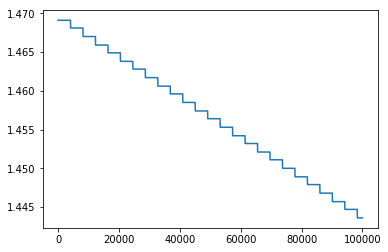

In [7]:
plt.plot(dataset['time_to_failure'][:100000])

This stepped nature must be something to do with the instrument that is timing the experiment? The time between values is basically zero between steps

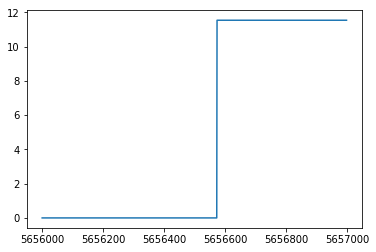

In [26]:
plt.plot(dataset['time_to_failure'][5656000:5657000])

On a larger scale we can see how the time to next failure decreases to zero and then jumps back up again

The sampling frequency is very high, so it makes sense to try to downsample to reduce the size of the dataset. We could try to take advantage of the 'stepped' nature of the data and just choose samples at the edge of each step. Or we could just choose to sample at some reasonable interval 

In [27]:
def downsample(dataframe,interval):
    
    return dataframe.iloc[::interval]


In [28]:
downsampled_data = downsample(dataset,4000)

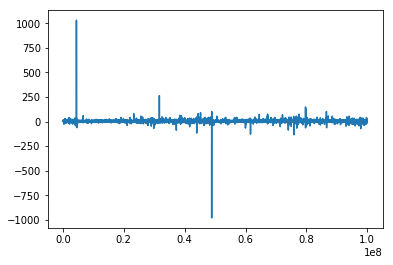

In [30]:
downsampled_data['acoustic_data'].plot()

There are some anaomlies in here - will probably want to apply a despike filter to remove them

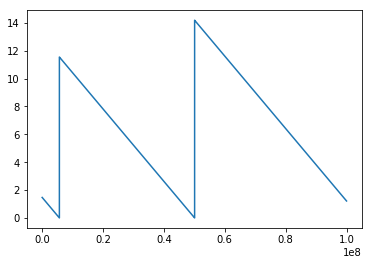

In [31]:
downsampled_data['time_to_failure'].plot()

Here we can see some earthquake events

### Designing a class to extract statistical features from chunks of data

We'll want to divide the data up into chunks of some size, calculate features from the data within those chunks and then train a regression algorithm to predict the time to failure from each chunk. Chunk size will be an important parameter to vary

In [34]:
len(downsampled_data)//500

50

In [98]:
class feature_calc:
    
    '''
    We should try to calculate as many features as possible
    '''
    
    def __init__(self):
        
        '''
        Takes in a chunk of data as a numpy array and calculates features
        '''
        
    def load_ts(self,inputdata):
        
        '''
        Load a new chunk
        '''
        
        self.indata = inputdata
    
    def calculate_features(self):
        
        '''
        Loop over feature functions and append features to an array
        '''
        
        features = [self.mean,self.median,self.peak,self.kurtosis,self.time_to_failure]
        arr = np.zeros(len(features))
        
        for i in range(len(features)):
        
            feature_func = features[i]
            arr[i] = feature_func()
            
        return arr
    
    ########################
    #Feature calculators
    ########################
    
    def time_to_failure(self):
        
        '''
        Get the time to failure of from the final row of the segment
        This is what we want to predict
        '''
        
        return self.indata[-1,1]
        
    
    def mean(self):
        
        '''
        Return mean of acoustic data for chunk
        '''
        
        return np.mean(self.indata[:,0])
    
    def median(self):
        
        '''
        Return median of acoustic data for chunk
        '''
        
        return np.median(self.indata[:,0])
    
    def peak(self):
        
        '''
        Return peak value of acoustic data for chunk
        '''
        
        return np.max(abs(self.indata[:,0]))
    
    def kurtosis(self):
        
        '''
        Return kurtosis of acoustic data for chunk
        '''
        
        return stats.kurtosis(self.indata[:,0])

In [99]:
class generate_feature_df:
    
    
    def __init__(self,input_data,chunk_size,stride):
        
        self.dataset = np.array(input_data)
        self.chunksize = chunk_size
        self.stride = stride
        self.FC = feature_calc()
        
        #These are the feature labels and should be in the same order as the features
        #that get calculated in feature_calc
        
        self.labels = ['mean','median','peak','kurtosis','time_to_failure']
        
    def process(self):
        
        '''
        Loop though the dataset, extract chunks of a given size at a given stride
        Then calculate features for that chunk and append them to a dataframe
        '''
        
        nchunks = len(self.dataset)//self.stride
        
        index = 0
        for i in range(nchunks):
            chunk = self.dataset[index:index+self.chunksize,:]
            index += self.stride
            self.FC.load_ts(chunk)
            arr = self.FC.calculate_features()
            
            if i == 0:
                data_segmented = arr
            else:
                data_segmented = np.vstack((data_segmented,arr))
                
        
                        
        return pd.DataFrame(data_segmented,columns=self.labels)
        
      

In [100]:
a = generate_feature_df(downsampled_data,500,100)
training_df = a.process()